In [6]:
import torch
from torch.utils.data import DataLoader
from torch import nn
import numpy as np
import sys
from utils import data
from utils.data import COCODataset
import matplotlib.pyplot as plt

In [2]:
#### Read in data

## Get image set with only one class
train_images, train_dataset_size, train_classes, train_coco = data.filterDataset('dataset', 'train')
val_images, val_dataset_size, val_classes, val_coco = data.filterDataset('dataset', 'val')

batch_size = 4
input_image_size = (224,224)
mask_type = 'normal'

val_gen = data.dataGeneratorCoco(val_images, val_coco, 'dataset',
                            input_image_size, batch_size, 'val', mask_type)

loading annotations into memory...
Done (t=15.37s)
creating index...
index created!
loading annotations into memory...
Done (t=0.55s)
creating index...
index created!


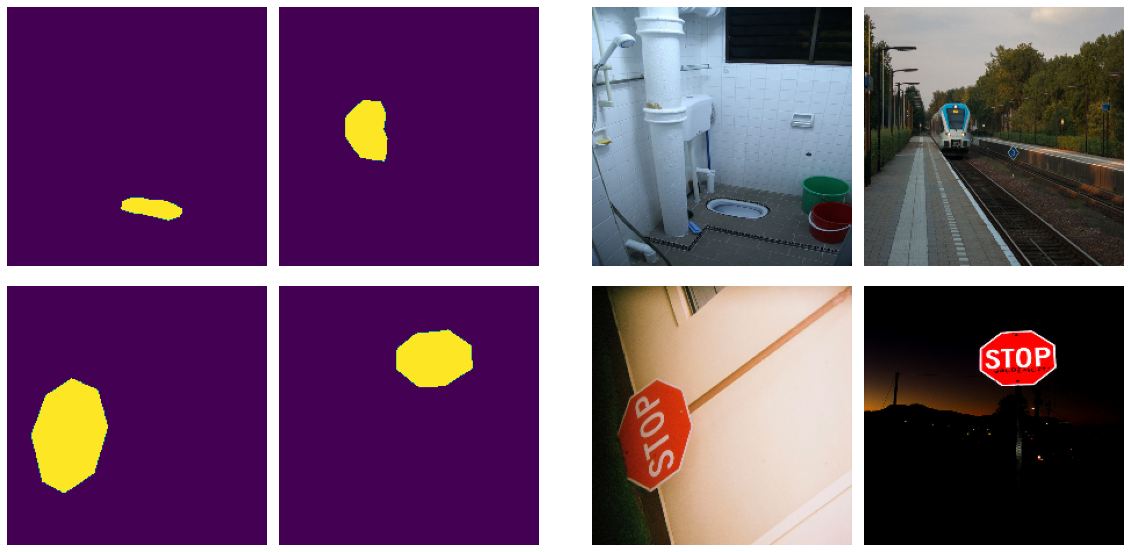

In [3]:
## Visualize generator

data.visualizeGenerator(val_gen)

### Questions

- ~Walkthrough of how the generator works~
- ~Why do we have: if c + batchsize >= dataset_size, shuffle image?~
- ~Does the generator loop forever? Need a way to split training into epochs where we see all data once per epoch (easiest way to do this is with PyTorch dataloader object)~
- ~How to convert this generator into a PyTorch dataset and dataloader?~
- ~How to get a batch of classId? img and mask are in batches, but classId is only a single value. Need a batch of classIds too~

In [4]:
for img, mask, classId in val_gen:
    print(classId)
    print(img.shape)
    print(mask.shape)
    print(classId.shape)
    print()
    break

19
(4, 224, 224, 3)
(4, 224, 224, 1)


AttributeError: 'int' object has no attribute 'shape'

In [ ]:
for img, mask, classId in val_gen:
    print(classId)

70
16
1
86
20
16
60
85
1
20
65
81
8
23
56
7
88
5
16
28
73
70
25
59
81
6
17
13
41
79
4
7
22
59
15
18
85
16
33
19
59
81
25
20
24
25
16
55
86
80
4
21
86
17
5
5
14
85
70
25
17
38
70
13
19
70
1
85
5
25
24
86
15
7
9
19
87
11
90
25
23
65
7
10
9
23
88
6
7
1
85
16
13
59
70
10
16
85
70
5
7
21
18
60
16
18
88
16
5
13
18
85
70
20
86
5
25
9
87
2
20
7
17
85
16
13
24
85
13
18
85
21
13
70
5
13
19
86
81
15
16
18
18
88
15
60
18
13
8
23
38
22
77
3
25
11
13
15
47
5
5
16
7
13
4
16
19
17
81
21
7
16
16
70
23
16
10
24
70
18
1
65
1
16
20
86
8
88
52
60
62
85
16
70
22
25
17
16
85
7
17
70
23
16
5
1
59
23
21
23
87
21
25
16
9
2
85
19
60
52
85
5
6
16
88
86
13
86
14
38
1
85
85
17
86
13
70
23
5
17
86
65
5
77
2
81
10
88
23
7
25
70
13
85
7
16
24
2
9
20
86
77
7
85
61
24
5
7
9
33
19
7
5
86
65
55
85
5
85
38
17
22
24
18
81
14
59
17
24
15
25
23
70
85
22
59
70
56
9
60
13
5
86
70
38
24
21
85
2
7
82
62
56
23
3
85
41
70
24
7
16
85
25
25
52
70
23
5
13
1
16
7
18
16
17
70
85
11
5
88
70
17
85
85
88
7
90
24
15
23
52
19
16
23
85
22
7
8

70
78
23
61
11
16
16
85
19
70
65
82
5
3
85
13
23
11
25
19
25
8
6
36
7
25
5
16
16
17
10
65
86
21
8
13
5
13
1
70
7
1
41
38
25
5
13
23
25
88
1
7
88
70
70
1
17
65
48
7
59
7
16
15
86
54
23
5
86
6
85
82
85
85
85
9
17
70
19
70
4
5
59
11
70
18
85
19
5
16
16
86
85
2
16
7
17
54
2
24
77
61
21
23
17
5
70
11
33
11
15
7
70
8
23
81
20
85
25
88
16
81
5
85
23
19
7
65
60
22
17
87
59
65
5
13
56
86
88
59
52
14
24
10
10
73
16
7
25
81
52
25
15
7
36
82
23
6
23
65
25
15
23
38
25
87
81
13
19
25
10
19
59
61
13
85
22
5
70
70
16
85
22
10
4
7
9
33
13
23
7
7
19
87
22
81
5
70
15
2
15
85
70
25
79
16
87
7
85
25
86
70
21
5
13
5
65
70
5
70
23
85
88
13
5
15
70
70
11
16
5
77
5
1
17
23
28
25
54
88
23
23
70
85
24
85
2
85
11
85
21
1
70
11
59
19
61
88
24
21
24
22
19
5
13
7
61
5
70
88
59
11
70
85
70
14
22
5
58
17
16
78
5
25
15
5
7
13
17
15
23
38
5
7
7
23
59
70
8
9
86
4
52
85
25
5
78
5
13
88
1
5
2
70
5
87
25
16
60
56
24
18
19
82
85
16
86
4
7
87
7
59
11
11
25
22
7
16
5
56
3
25
70
16
7
85
13
85
86
1
85
81
19
7
23
22
7
23
85
16
7


11
1
90
5
85
70
7
5
85
85
81
7
11
20
25
19
65
40
24
59
48
20
81
23
15
5
7
86
88
17
5
70
10
85
21
18
13
16
6
5
59
77
59
85
16
25
19
88
6
41
22


In [ ]:
for img, mask, classId in val_gen:  # can no longer iterate through the generator
    print(classId)

### Test dataset outputs

loading annotations into memory...
Done (t=0.49s)
creating index...
index created!
torch.Size([4, 3, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4])



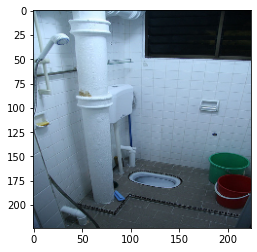

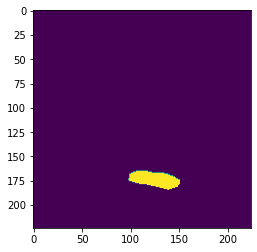

mask_vals: [0. 1.]


In [19]:
val_dataset = COCODataset(folder='dataset', mode='val')
val_loader = DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)
for image, mask, classId in val_loader:
    print(image.shape)
    print(mask.shape)
    print(classId.shape)
    print()
    plt.imshow(image[0, :, :, :].permute(1, 2, 0))
    plt.show()
    plt.imshow(mask[0, :, :, :].permute(1, 2, 0))
    plt.show()
    print(f'mask_vals: {np.unique(mask)}')
    break

#### MTL Architecture

In [87]:
class MTLUNet(nn.Module):
    def __init__(self, num_channels=3, num_classes=90):
        super(MTLUNet, self).__init__()
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # Encoding #
        self.enc0 = nn.Sequential(nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(64),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(64),
                                  nn.Dropout(p=0.5))
        self.enc1 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64, out_channels=128, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128),
                                  nn.Dropout(p=0.5))
        self.enc2 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+128, out_channels=256, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(256),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(256),
                                  nn.Dropout(p=0.5))
        self.enc3 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+128+256, out_channels=512, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(512),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(512),
                                  nn.Dropout(p=0.5))
        
        # Shared Base #
        self.shared_base = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+128+256+512, out_channels=1024, kernel_size=3, stride=1, padding=1),
                                         nn.ReLU(),
                                         nn.BatchNorm2d(1024),
                                         nn.Dropout(p=0.5))
        
        # Task-specific Bases
        self.seg_base = nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(1024),
                                      nn.Dropout(p=0.5),
                                      nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2, padding=0),
                                      nn.ReLU(),
                                      nn.BatchNorm2d(512),
                                      nn.Dropout(p=0.5))
        self.class_base = nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(1024),
                                        nn.Dropout(p=0.5))    
        
        # Task 1: Segmentation #
        self.seg3 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+128+256+1024, out_channels=512, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(512),
                                  nn.Dropout(p=0.5),
                                  nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, padding=0))
        self.seg2 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+128+512, out_channels=256, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(256),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(256),
                                  nn.Dropout(p=0.5),
                                  nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0))
        self.seg1 = nn.Sequential(nn.Conv2d(in_channels=num_channels+64+256, out_channels=128, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128),
                                  nn.Dropout(p=0.5),
                                  nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0))
        self.seg0 = nn.Sequential(nn.Conv2d(in_channels=num_channels+128, out_channels=64, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(64),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(64),
                                  nn.Dropout(p=0.5),
                                  nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1))
        
        # Task 2: Classification #
        self.class3 = nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(1024),
                                    nn.Dropout(p=0.5),
                                    nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(512),
                                    nn.Dropout(p=0.5))
        self.class2 = nn.Sequential(nn.Conv2d(in_channels=1024+512, out_channels=256, kernel_size=5, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(256),
                                    nn.Dropout(p=0.5),
                                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=5, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(256),
                                    nn.Dropout(p=0.5))
        self.class1 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=128, kernel_size=5, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(128),
                                    nn.Dropout(p=0.5),
                                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(128),
                                    nn.Dropout(p=0.5))
        self.class0 = nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=1, stride=1, padding=0)
        
    def forward(self, X):
        # Encoding
        
        # Lvl 0
        print(f'X shape, X_0 input: {X.shape}')
        X_0 = self.enc0(X)
        print(f'X_0 shape: {X_0.shape}')
        X_0 = torch.cat((X, X_0), dim=1)  # dense connection
        print(f'X_0 shape: {X_0.shape}')
        X_0_mp = self.maxpool(X_0)
        print(f'X_0_mp, X_1 input shape: {X_0_mp.shape}')
        
        # Lvl 1
        X_1 = self.enc1(X_0_mp)
        X_1 = torch.cat((X_0_mp, X_1), dim=1)  # dense connection
        X_1_mp = self.maxpool(X_1)
        print(f'X_1_mp, X_2 input shape: {X_1_mp.shape}')
        
        # Lvl 2
        X_2 = self.enc2(X_1_mp)
        X_2 = torch.cat((X_1_mp, X_2), dim=1)  # dense connection
        X_2_mp = self.maxpool(X_2)
        print(f'X_2_mp, X_3 input shape: {X_2_mp.shape}')
        
        # Lvl 3
        X_3 = self.enc3(X_2_mp)
        X_3 = torch.cat((X_2_mp, X_3), dim=1)  # dense connection
        X_3_mp = self.maxpool(X_3)
        print(f'X_3_mp, shared_base input shape: {X_3_mp.shape}')
        
        # Base
        shared_base = self.shared_base(X_3_mp)
        print(f'shared_base output shape: {shared_base.shape}')
        
        # Task 1: Segmentation
        seg_output = self.seg_base(shared_base)
        print(f'seg_base output shape: {seg_output.shape}')
        seg_output = torch.cat((X_3, seg_output), dim=1)  # skip connection
        print(f'seg3 input shape: {seg_output.shape}')
        seg_output = self.seg3(seg_output)
        print(f'seg3 output shape: {seg_output.shape}')
        
        seg_output = torch.cat((X_2, seg_output), dim=1)  # skip connection
        seg_output = self.seg2(seg_output)
        print(f'seg2 output shape: {seg_output.shape}')
        
        seg_output = torch.cat((X_1, seg_output), dim=1)  # skip connection
        seg_output = self.seg1(seg_output)
        print(f'seg1 output shape: {seg_output.shape}')
        
        seg_output = torch.cat((X_0, seg_output), dim=1)  # skip connection
        print(f'seg0 input shape: {seg_output.shape}')
        seg_output = self.seg0(seg_output)
        print(f'seg0 output shape: {seg_output.shape}')
        
        # Task 2: Classification
        print(f'class3 input shape: {shared_base.shape}')
        class_output = self.class3(shared_base)
        class_output = torch.cat((shared_base, class_output), dim=1)  # dense connection
        print(f'class3 output shape: {class_output.shape}')
        class_output = self.class2(class_output)
        print(f'class2 output shape: {class_output.shape}')
        class_output = self.class1(class_output)
        print(f'class1 output shape: {class_output.shape}')
        class_output = self.class0(class_output)
        print(f'class0 output shape: {class_output.shape}')
        
        return seg_output, class_output
        

### Test MTLUNet Forward Pass

In [88]:
dummy_data = torch.zeros((4, 3, 224, 224))

mtlunet = MTLUNet()
mtlunet(dummy_data)

X shape, X_0 input: torch.Size([4, 3, 224, 224])
X_0 shape: torch.Size([4, 64, 224, 224])
X_0 shape: torch.Size([4, 67, 224, 224])
X_0_mp, X_1 input shape: torch.Size([4, 67, 112, 112])
X_1_mp, X_2 input shape: torch.Size([4, 195, 56, 56])
X_2_mp, X_3 input shape: torch.Size([4, 451, 28, 28])
X_3_mp, shared_base input shape: torch.Size([4, 963, 14, 14])
shared_base output shape: torch.Size([4, 1024, 14, 14])
seg_base output shape: torch.Size([4, 512, 28, 28])
seg3 input shape: torch.Size([4, 1475, 28, 28])
seg3 output shape: torch.Size([4, 256, 56, 56])
seg2 output shape: torch.Size([4, 128, 112, 112])
seg1 output shape: torch.Size([4, 64, 224, 224])
seg0 input shape: torch.Size([4, 131, 224, 224])
seg0 output shape: torch.Size([4, 90, 224, 224])
class3 input shape: torch.Size([4, 1024, 14, 14])
class3 output shape: torch.Size([4, 1536, 14, 14])
class2 output shape: torch.Size([4, 256, 6, 6])
class1 output shape: torch.Size([4, 128, 1, 1])
class0 output shape: torch.Size([4, 90, 1, 1])

(tensor([[[[ 1.8341e-01, -6.3250e-01,  1.7674e-01,  ..., -4.2447e-01,
            -7.9687e-01,  4.7866e-02],
           [ 2.3035e-02,  9.0134e-01, -1.9184e-01,  ..., -4.2639e-01,
             3.3612e-02, -2.8944e-01],
           [ 1.2720e-01,  6.9334e-01, -5.8110e-01,  ..., -3.1548e-01,
             5.4058e-01,  5.8366e-02],
           ...,
           [-8.2353e-02,  6.3479e-02,  1.5958e+00,  ...,  1.4982e+00,
            -2.6335e-01,  4.4671e-02],
           [-2.2285e-01, -1.6526e-01, -5.2543e-01,  ..., -1.2241e+00,
             7.3530e-02,  5.4928e-01],
           [-2.3791e-01, -8.3637e-02,  5.7786e-01,  ...,  9.0539e-01,
             2.4843e-01, -8.4215e-01]],
 
          [[-2.4788e-01, -1.4734e-01,  8.4300e-02,  ..., -2.7407e-01,
            -9.6136e-01,  4.1885e-02],
           [ 3.7959e-01,  6.1248e-01, -2.8237e-01,  ..., -2.7095e-01,
             3.8157e-01,  1.7540e-01],
           [ 5.6578e-01, -8.8728e-01,  3.7653e-02,  ..., -5.3003e-01,
            -1.6823e-01, -6.0837e-01],


### Next steps for data

- ~Image data should have shape (batch_size, num_channels, height, width), but currently has shape (batch_size, height, width, num_channels): https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html~
- ~Make data generator into PyTorch dataloader object: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html~
- Make segmentation mask have same values as class label

### Next steps for architecture

- ~Finalize class branch~
- ~Add skip connections~
- ~Add densenet-style concatenation connections~
- ~Update forward pass~

### Next steps for training

- Implement combined loss
- Create training loop

### Next steps for pruning

- Implement basic pruning
- Implement task-specific pruning, specified by input task
- Implement one-shot pruning

### Scratch Work

In [ ]:
### Get number of classes
classIds = []
train_gen = data.dataGeneratorCoco(train_images, train_coco, 'dataset',
                                   input_image_size, batch_size, 'train', mask_type)
for img, mask, classId in train_gen:
    classIds.append(classId)
print(len(set(classIds)))